<a href="https://colab.research.google.com/github/jainsanyam228/ML-Diabetic-Retinopathy-/blob/main/ownmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers.pooling import MaxPooling2D
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from typeguard import typechecked
from typing import Optional
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/aptos_ml_data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/aptos_ml_data/test.csv')
submission= pd.read_csv('/content/drive/MyDrive/aptos_ml_data/sample_submission.csv')

FileNotFoundError: ignored

In [ ]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


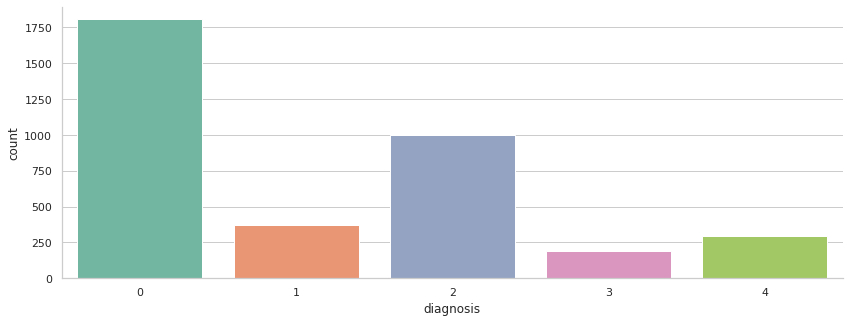

In [ ]:
f, ax = plt.subplots(figsize=(14, 5))
ax = sns.countplot(x="diagnosis", data=train, palette="Set2")
sns.despine()
plt.show()

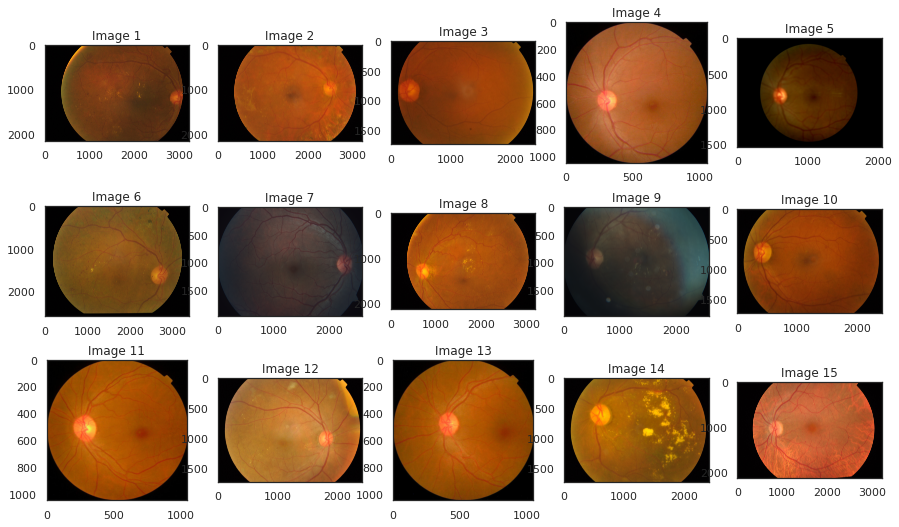

In [ ]:
sns.set_style("white")
count = 1
plt.figure(figsize=[15, 15])
for img_name in train['id_code'][:15]:
    img = cv2.imread("/content/drive/MyDrive/aptos_ml_data/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1

plt.show()

In [ ]:
N_CLASSES = train['diagnosis'].nunique()
N_CLASSES

5

In [ ]:
# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/aptos_ml_data/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",
    target_size=(224, 224),
    subset='training')

Found 2930 validated image filenames belonging to 5 classes.


In [ ]:
valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/aptos_ml_data/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",
    target_size=(224, 224),
    subset='validation')

Found 732 validated image filenames belonging to 5 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory = "/content/drive/MyDrive/aptos_ml_data/test_images",
        x_col="id_code",
        target_size=(224, 224),
        batch_size=16,
        shuffle=False,
        class_mode=None)

Found 1928 validated image filenames.


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(activation='softmax', units=5))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      36928     
                                                        

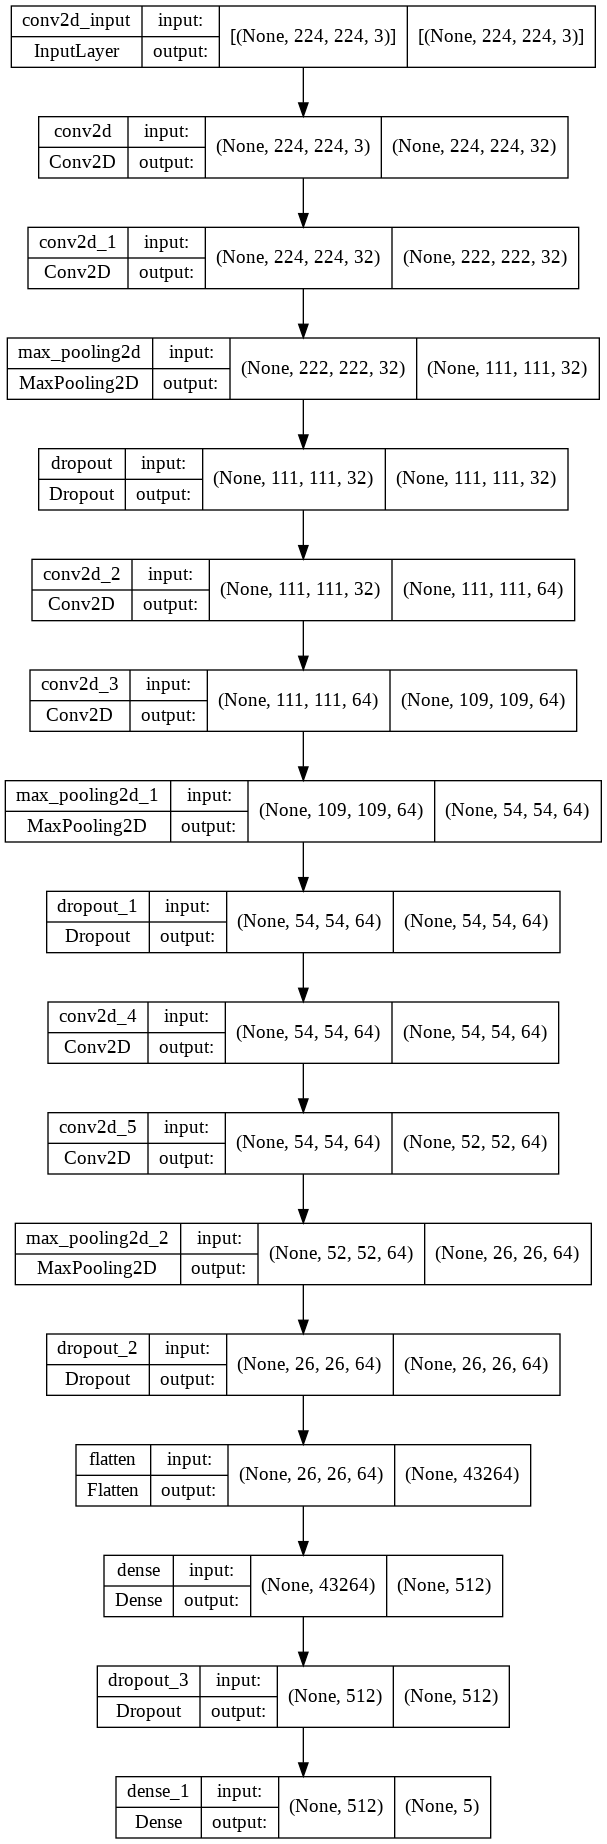

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet5.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet5.png')

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]


In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 2,verbose = 1,factor = 0.8, min_lr = 1e-6)

mcp = ModelCheckpoint('ownmodel.h5')

es = EarlyStopping(verbose=1, patience=2)

In [ ]:
model.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=METRICS)

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

In [ ]:
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

183
45


In [ ]:

history = model.fit_generator(generator=train_generator,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,epochs=20)

Epoch 1/20
183/183 [==============================] - 2078s 11s/step - loss: 1.0629 - accuracy: 0.8583 - precision: 0.7849 - recall: 0.4019 - auc: 0.8581 - f1_score: 0.5004 - val_loss: 0.8736 - val_accuracy: 0.8758 - val_precision: 0.9050 - val_recall: 0.4236 - val_auc: 0.9107 - val_f1_score: 0.5694
Epoch 2/20
183/183 [==============================] - 690s 4s/step - loss: 0.8286 - accuracy: 0.8907 - precision: 0.8366 - recall: 0.5638 - auc: 0.9136 - f1_score: 0.6680 - val_loss: 0.7727 - val_accuracy: 0.8911 - val_precision: 0.8534 - val_recall: 0.5500 - val_auc: 0.9254 - val_f1_score: 0.6610
Epoch 3/20
183/183 [==============================] - 679s 4s/step - loss: 0.8107 - accuracy: 0.8953 - precision: 0.8363 - recall: 0.5927 - auc: 0.9176 - f1_score: 0.6905 - val_loss: 0.7938 - val_accuracy: 0.8858 - val_precision: 0.8635 - val_recall: 0.5097 - val_auc: 0.9201 - val_f1_score: 0.6357
Epoch 4/20
183/183 [==============================] - 679s 4s/step - loss: 0.7965 - accuracy: 0.8978 

In [ ]:
model.save('/content/drive/MyDrive/modelEpoch20f.h5')

In [ ]:
model.save('/content/drive/MyDrive/modelEpoch20_allFilesf')

In [ ]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

In [ ]:
plt.figure(1,figsize=(7,5))
plt.plot(epochs,train_loss)
plt.plot(epochs,val_loss)
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

In [ ]:
plt.figure(2,figsize=(7,5))
plt.plot(epochs,train_acc)
plt.plot(epochs,val_acc)
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])


In [ ]:
score =model.evaluate_generator(generator=valid_generator)
print(score)

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(
        dataframe=train,
        directory = "/content/drive/MyDrive/aptos_ml_data/train_images/",
        x_col="id_code",
        target_size=(224, 224),
        batch_size=1,
        shuffle=False,
        class_mode=None)

In [ ]:
STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds =model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(15, 8))
sns.heatmap(df_cm, annot=True, fmt='.2f')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/modelEpoch20_allFiles')